# CTDS Initialization Diagnostics

This notebook provides comprehensive diagnostics for CTDS (Cell-Type Constrained Dynamical Systems) initialization procedures, focusing on:

1. **J Matrix Estimation Diagnostics** - Validation of Dale's law constrained connectivity matrix estimation
2. **Blockwise NMF Factorization Diagnostics** - Analysis of non-negative matrix factorization for cell-type specific dynamics

## Overview

The CTDS initialization process involves:
- Estimating the Dale matrix J from neural activity using constrained optimization
- Performing blockwise NMF to extract cell-type specific latent factors
- Converting these factors into state-space model parameters

This notebook validates each step with quantitative metrics and visualizations.

In [1]:
# Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Optional
import time
from functools import partial

# Configure JAX for float64 precision
jax.config.update("jax_enable_x64", True)

# Import CTDS modules
from models import CTDS
from params import (
    ParamsCTDS, ParamsCTDSInitial, ParamsCTDSDynamics, 
    ParamsCTDSEmissions, ParamsCTDSConstraints
)
from utlis import estimate_J, blockwise_NMF, NMF
from simulation_utilis import generate_synthetic_data, generate_CTDS_Params
from inference import DynamaxLGSSMBackend

# Set random seeds for reproducibility
np.random.seed(42)
key = jr.PRNGKey(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Setup complete!")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"JAX backend: {jax.default_backend()}")

✅ Setup complete!
JAX version: 0.4.38
JAX devices: [CpuDevice(id=0)]
JAX backend: cpu


## Generate Synthetic Data with Ground Truth

First, we'll generate synthetic neural data with known ground truth connectivity and cell types to validate our initialization procedures.

🔄 Generating synthetic neural data...
📊 Data Generated:
  • Observations shape: (200, 20)
  • States shape: (200, 6)
  • Cell types: [0 1]
  • Cell type dimensions: [3 3]
  • Cell type mask: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
  • Excitatory neurons: 10
  • Inhibitory neurons: 10

🎯 Ground Truth J Matrix:
  • Shape: (20, 20)
  • Norm: 2.449
  • Condition number: 5.08e+16


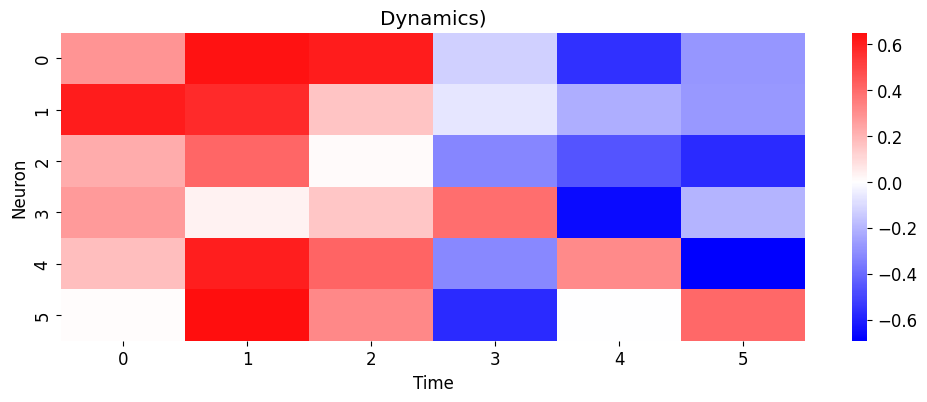

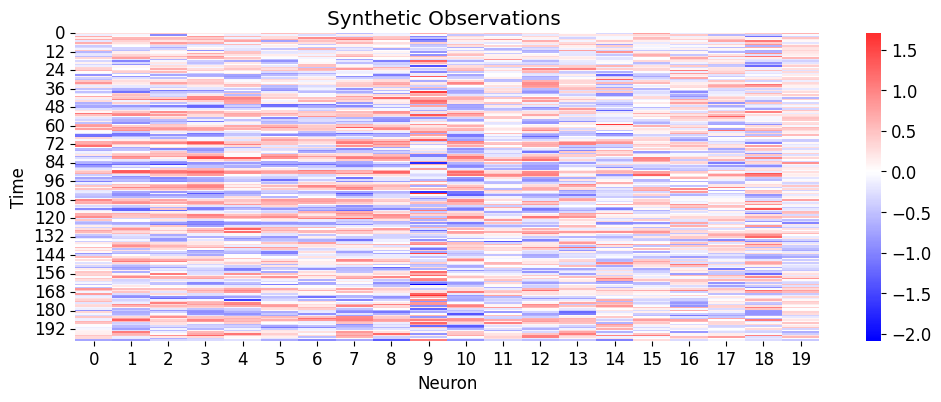

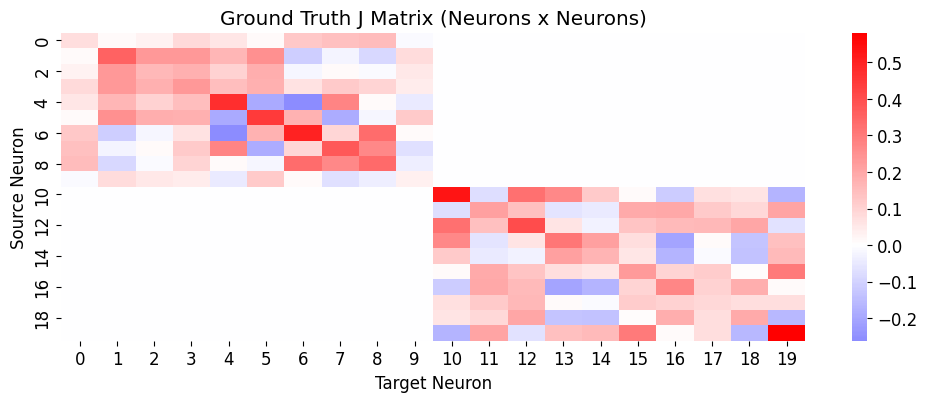

  • Observations shape: (200, 20)


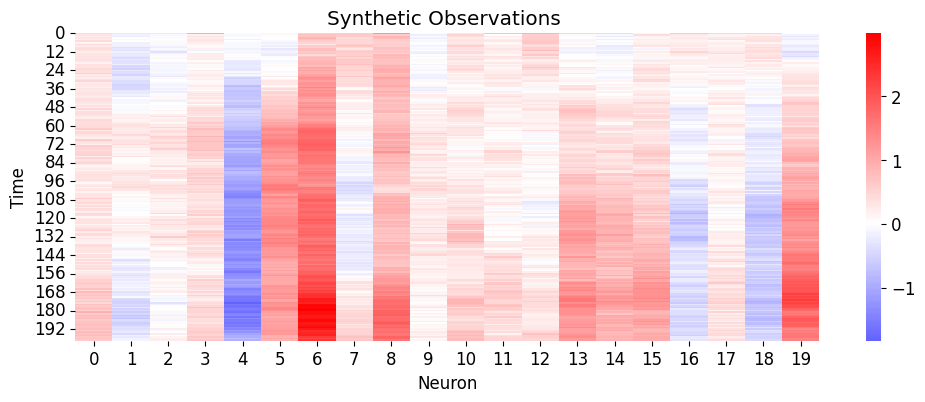

In [2]:
# Define dimensions and generate synthetic data
D = 6  # Total state dimension (3 excitatory + 3 inhibitory)
N = 20  # Number of observed neurons
T = 200  # Number of time steps
K = 2  # Number of cell types

print("🔄 Generating synthetic neural data...")
print("=" * 50)

# Generate synthetic data with ground truth parameters
states, observations, ctds_model, ctds_params = generate_synthetic_data(
    num_samples=1,
    num_timesteps=T,
    state_dim=D,
    emission_dim=N,
    cell_types=K
)


# Extract ground truth parameters for comparison
A_true = ctds_params.dynamics.weights
C_true = ctds_params.emissions.weights
Q_true = ctds_params.dynamics.cov
R_true = ctds_params.emissions.cov

# Extract cell type information
cell_constraints = ctds_model.constraints
cell_type_mask = cell_constraints.cell_type_mask
cell_types = cell_constraints.cell_types
cell_type_dimensions = cell_constraints.cell_type_dimensions

def generate_states_from_dynamics(
    A: jnp.ndarray,
    Q: jnp.ndarray,
    num_timesteps: int,
    key: jax.random.PRNGKey,
    x0: Optional[jnp.ndarray] = None
) -> jnp.ndarray:
    """
    Generate states using dynamics: x_{t+1} = A @ x_t + w_t, where w_t ~ N(0, Q)
    
    Args:
        A: (D, D) state transition matrix
        Q: (D, D) or (D,) state noise covariance
        x0: (D,) initial state
        num_timesteps: Number of time steps
        key: Random key
        
    Returns:
        states: (D, T) array of states
    """
    
    D = A.shape[0]
    if x0 is None:
        x0 = jax.random.normal(key, (D,))

    # Handle both diagonal and full covariance
    if Q.ndim == 1:
        # Diagonal covariance
        noise_std = jnp.sqrt(Q)
        keys = jr.split(key, num_timesteps)
        state_noise = jnp.array([jr.normal(keys[t], (D,)) * noise_std for t in range(num_timesteps)]).T
    else:
        # Full covariance
        keys = jr.split(key, num_timesteps)
        state_noise = jnp.array([jr.multivariate_normal(keys[t], jnp.zeros(D), Q) for t in range(num_timesteps)]).T
    
    # Pre-allocate states
    states = jnp.zeros((D, num_timesteps))
    states = states.at[:, 0].set(x0)
    
    # Generate states iteratively
    for t in range(num_timesteps - 1):
        next_state = A @ states[:, t] + state_noise[:, t]
        states = states.at[:, t + 1].set(next_state)
    
    return states
    

def generate_observations_from_states(
    states: jnp.ndarray,
    C: jnp.ndarray,
    R: jnp.ndarray,
    key: jax.random.PRNGKey = jr.PRNGKey(42)
) -> jnp.ndarray:
    """
    Generate observations from states using the emission model: y_t = C @ x_t + v_t
    where v_t ~ N(0, R) is emission noise.
    
    Args:
        states: (D, T) array of latent states over time
        C: (N, D) emission matrix mapping states to observations
        R: (N, N) emission covariance matrix or (N,) diagonal covariance
        key: Random key for noise generation
        
    Returns:
        observations: (N, T) array of observations
    """
    
    D, T = states.shape
    N = C.shape[0]
    
    # Validate dimensions
    #assert C.shape == (N, D), f"C shape {C.shape} incompatible with states shape {states.shape}"
    
    # Handle both full covariance and diagonal covariance
    if R.ndim == 1:
        # Diagonal covariance - R is (N,) vector of variances
        assert R.shape == (N,), f"Diagonal R shape {R.shape} incompatible with N={N}"
        noise_std = jnp.sqrt(R)
        
        # Generate independent noise for each dimension
        keys = jr.split(key, T)
        noise = jnp.array([jr.normal(keys[t], (N,)) * noise_std for t in range(T)]).T
        
    elif R.ndim == 2:
        # Full covariance matrix - R is (N, N)
        assert R.shape == (N, N), f"Full R shape {R.shape} incompatible with N={N}"
        
        # Generate multivariate normal noise
        keys = jr.split(key, T)
        noise = jnp.array([jr.multivariate_normal(keys[t], jnp.zeros(N), R) for t in range(T)]).T
        
    else:
        raise ValueError(f"R must be 1D (diagonal) or 2D (full covariance), got shape {R.shape}")
    
    # Generate observations: y_t = C @ x_t + v_t
    linear_observations = C @ states  # (N, T)
    observations = linear_observations + noise  # (N, T)
    
    return observations.T

def simulate_observations_from_J(
    J: jnp.ndarray,
    num_timesteps: int,
    initial_obs: Optional[jnp.ndarray] = None,
    noise_std: float = 0.1,
    key: jax.random.PRNGKey = jr.PRNGKey(42)
) -> jnp.ndarray:
    """
    Simulate observations using autoregressive dynamics: y_t = J @ y_{t-1} + noise
    
    Args:
        J: (N, N) connectivity/transition matrix
        num_timesteps: Number of time steps to simulate
        initial_obs: (N,) initial observation. If None, random initialization
        noise_std: Standard deviation of observation noise
        key: Random key for noise generation
        
    Returns:
        observations: (N, T) array of simulated observations over time
    """
    
    N = J.shape[0]
    
    # Validate J matrix
    assert J.shape == (N, N), f"J must be square, got shape {J.shape}"
    
    keys = jr.split(key, num_timesteps + 1)
    
    # Initialize observations
    if initial_obs is None:
        initial_obs = jr.normal(keys[0], (N,)) * 0.5
    else:
        assert initial_obs.shape == (N,), f"Initial obs shape {initial_obs.shape} incompatible with J shape {J.shape}"
    
    # Pre-allocate observations array
    observations = jnp.zeros((N, num_timesteps))
    observations = observations.at[:, 0].set(initial_obs)
    
    # Simulate dynamics: y_t = J @ y_{t-1} + noise
    for t in range(1, num_timesteps):
        # Linear dynamics
        predicted_obs = J @ observations[:, t-1]
        
        # Add noise
        noise = jr.normal(keys[t], (N,)) * noise_std
        next_obs = predicted_obs + noise
        
        # Store observation
        observations = observations.at[:, t].set(next_obs)
    
    return observations.T




print(f"📊 Data Generated:")
print(f"  • Observations shape: {observations.shape}")
print(f"  • States shape: {states.shape}")
print(f"  • Cell types: {cell_types}")
print(f"  • Cell type dimensions: {cell_type_dimensions}")
print(f"  • Cell type mask: {cell_type_mask}")
print(f"  • Excitatory neurons: {jnp.sum(cell_type_mask == 0)}")
print(f"  • Inhibitory neurons: {jnp.sum(cell_type_mask == 1)}")

# Create ground truth J matrix from C and A
# J represents the effective connectivity: Y_t+1 ≈ J @ Y_t
# For linear-Gaussian SSM: Y = CA(CA)^†Y + noise
# So J ≈ CA(CA)^† where (CA)^† is the pseudoinverse
CA = C_true @ A_true
CA_pinv = jnp.linalg.pinv(CA)
J_true = CA @ CA_pinv

observations = generate_observations_from_states(states.T, C_true, R_true, key=jr.PRNGKey(42))

print(f"\n🎯 Ground Truth J Matrix:")
print(f"  • Shape: {J_true.shape}")
print(f"  • Norm: {jnp.linalg.norm(J_true, 'fro'):.3f}")
print(f"  • Condition number: {jnp.linalg.cond(J_true):.2e}")

plt.figure(figsize=(12, 4))
sns.heatmap(np.array(A_true),center=0, cmap='bwr', cbar=True)
plt.title('Dynamics)')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(np.array(observations),center=0, cmap='bwr', cbar=True)
plt.title('Synthetic Observations ')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(np.array(J_true),center=0, cmap='bwr', cbar=True)
plt.title('Ground Truth J Matrix (Neurons x Neurons)')
plt.xlabel('Target Neuron')
plt.ylabel('Source Neuron')
plt.show()

obs=simulate_observations_from_J(J_true, num_timesteps=T, noise_std=0.1)
print(f"  • Observations shape: {obs.shape}")
plt.figure(figsize=(12, 4))
sns.heatmap(np.array(obs),center=0, cmap='bwr', cbar=True)
plt.title('Synthetic Observations ')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()

## 1. J Matrix Estimation Diagnostics

We estimate the Dale's law constrained connectivity matrix J from neural activity and validate it against ground truth.

🔍 ESTIMATING J MATRIX FROM NEURAL ACTIVITY
(20,)
(200, 20)
✅ J Matrix Estimation Completed:
  • Estimation time: 2.669 seconds
  • Estimated J shape: (20, 20)
  • Estimated J norm: 2.141
  • Condition number: 2.33e+02

📊 J Matrix Quality Metrics:
  • Pearson correlation: 0.1911
  • Relative Frobenius error: 1.1704
  • Prediction MSE: 0.153589
  • Baseline MSE: 0.269466
  • Normalized MSE: 0.5700
  • Prediction R²: 0.4312
  • Observations shape: (200, 20)


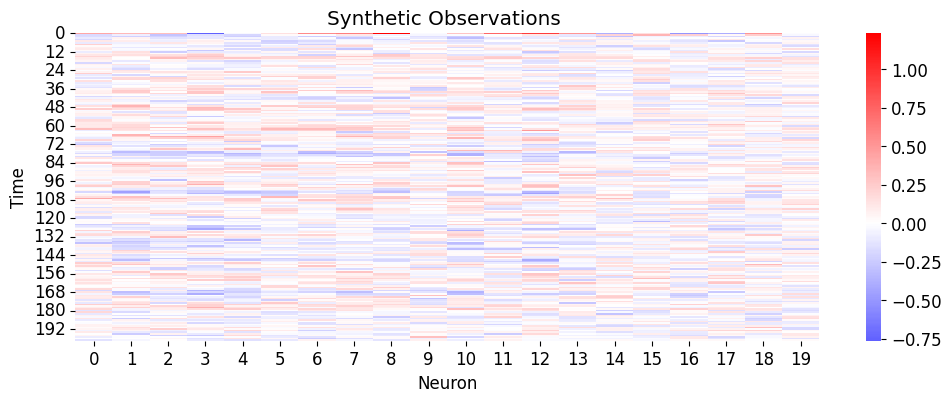

In [3]:
print("🔍 ESTIMATING J MATRIX FROM NEURAL ACTIVITY")
print("=" * 60)

# Create Dale's law mask (True for excitatory, False for inhibitory)
dale_mask = (cell_type_mask == 0)  # Excitatory = True, Inhibitory = False
print(dale_mask.shape)
print(observations.shape)

# Estimate J matrix using constrained optimization
start_time = time.time()
J_estimated = estimate_J(observations.T, dale_mask)
estimation_time = time.time() - start_time

print(f"✅ J Matrix Estimation Completed:")
print(f"  • Estimation time: {estimation_time:.3f} seconds")
print(f"  • Estimated J shape: {J_estimated.shape}")
print(f"  • Estimated J norm: {jnp.linalg.norm(J_estimated, 'fro'):.3f}")
print(f"  • Condition number: {jnp.linalg.cond(J_estimated):.2e}")

# Compute quantitative metrics
def compute_j_metrics(J_est, J_true, observations):
    """Compute comprehensive metrics for J matrix estimation."""
    
    # 1. Pearson correlation between flattened matrices
    J_est_flat = J_est.flatten()
    J_true_flat = J_true.flatten()
    correlation = jnp.corrcoef(J_est_flat, J_true_flat)[0, 1]
    
    # 2. Frobenius norm relative error
    frobenius_error = jnp.linalg.norm(J_est - J_true, 'fro') / jnp.linalg.norm(J_true, 'fro')
    
    # 3. One-step prediction test
    Y_past = observations[:, :-1]  # Shape: (N, T-1)
    Y_future_true = observations[:, 1:]  # Shape: (N, T-1)
    Y_future_pred = J_est @ Y_past  # Predicted future
    
    # Mean squared prediction error
    mse_prediction = jnp.mean((Y_future_pred - Y_future_true)**2)
    
    # Baseline MSE (predicting with mean)
    Y_mean = jnp.mean(observations, axis=1, keepdims=True)
    mse_baseline = jnp.mean((Y_mean - Y_future_true)**2)
    
    # Normalized MSE
    normalized_mse = mse_prediction / mse_baseline
    
    # R² for prediction
    ss_res = jnp.sum((Y_future_true - Y_future_pred)**2)
    ss_tot = jnp.sum((Y_future_true - jnp.mean(Y_future_true))**2)
    r2_prediction = 1 - (ss_res / ss_tot)
    
    return {
        'correlation': correlation,
        'frobenius_error': frobenius_error,
        'mse_prediction': mse_prediction,
        'mse_baseline': mse_baseline,
        'normalized_mse': normalized_mse,
        'r2_prediction': r2_prediction
    }

# Compute metrics
j_metrics = compute_j_metrics(J_estimated, J_true, observations.T)

print(f"\n📊 J Matrix Quality Metrics:")
print(f"  • Pearson correlation: {j_metrics['correlation']:.4f}")
print(f"  • Relative Frobenius error: {j_metrics['frobenius_error']:.4f}")
print(f"  • Prediction MSE: {j_metrics['mse_prediction']:.6f}")
print(f"  • Baseline MSE: {j_metrics['mse_baseline']:.6f}")
print(f"  • Normalized MSE: {j_metrics['normalized_mse']:.4f}")
print(f"  • Prediction R²: {j_metrics['r2_prediction']:.4f}")


J_obs = simulate_observations_from_J(J_estimated, num_timesteps=T, noise_std=0.1)
print(f"  • Observations shape: {J_obs.shape}")
plt.figure(figsize=(12, 4))
sns.heatmap(np.array(J_obs),center=0, cmap='bwr', cbar=True)
plt.title('Synthetic Observations ')
plt.ylabel('Time')
plt.xlabel('Neuron')
plt.show()

In [4]:
# Verify Dale's law constraints
print("\n🧬 DALE'S LAW VERIFICATION")
print("=" * 40)

def verify_dales_law(J, dale_mask):
    """Verify Dale's law constraints on estimated J matrix."""
    
    # Excitatory columns should have all non-negative entries
    excitatory_indices = jnp.where(dale_mask)[0]
    inhibitory_indices = jnp.where(~dale_mask)[0]
    
    # Check excitatory columns (all entries should be >= 0)
    excitatory_violations = []
    for col_idx in excitatory_indices:
        column = J[:, col_idx]
        negative_entries = jnp.sum(column < -1e-10)  # Allow small numerical errors
        if negative_entries > 0:
            excitatory_violations.append((col_idx, negative_entries, jnp.min(column)))
    
    # Check inhibitory columns (all entries should be <= 0)
    inhibitory_violations = []
    for col_idx in inhibitory_indices:
        column = J[:, col_idx]
        positive_entries = jnp.sum(column > 1e-10)  # Allow small numerical errors
        if positive_entries > 0:
            inhibitory_violations.append((col_idx, positive_entries, jnp.max(column)))
    
    return {
        'excitatory_violations': excitatory_violations,
        'inhibitory_violations': inhibitory_violations,
        'total_excitatory_cols': len(excitatory_indices),
        'total_inhibitory_cols': len(inhibitory_indices)
    }

# Verify Dale's law for estimated J
dale_results = verify_dales_law(J_estimated, dale_mask)

print(f"Excitatory columns ({dale_results['total_excitatory_cols']} total):")
if len(dale_results['excitatory_violations']) == 0:
    print(f"  ✅ All excitatory columns satisfy Dale's law (all entries ≥ 0)")
else:
    print(f"  ❌ {len(dale_results['excitatory_violations'])} violations found:")
    for col_idx, neg_count, min_val in dale_results['excitatory_violations']:
        print(f"    Column {col_idx}: {neg_count} negative entries, min = {min_val:.6f}")

print(f"\nInhibitory columns ({dale_results['total_inhibitory_cols']} total):")
if len(dale_results['inhibitory_violations']) == 0:
    print(f"  ✅ All inhibitory columns satisfy Dale's law (all entries ≤ 0)")
else:
    print(f"  ❌ {len(dale_results['inhibitory_violations'])} violations found:")
    for col_idx, pos_count, max_val in dale_results['inhibitory_violations']:
        print(f"    Column {col_idx}: {pos_count} positive entries, max = {max_val:.6f}")

# Compute Dale's law compliance percentage
total_violations = len(dale_results['excitatory_violations']) + len(dale_results['inhibitory_violations'])
total_columns = dale_results['total_excitatory_cols'] + dale_results['total_inhibitory_cols']
compliance_rate = (total_columns - total_violations) / total_columns * 100

print(f"\n📈 Dale's Law Compliance: {compliance_rate:.1f}% ({total_columns - total_violations}/{total_columns} columns)")


🧬 DALE'S LAW VERIFICATION
Excitatory columns (10 total):
  ❌ 1 violations found:
    Column 9: 1 negative entries, min = -0.000000

Inhibitory columns (10 total):
  ❌ 2 violations found:
    Column 11: 1 positive entries, max = 0.000000
    Column 18: 1 positive entries, max = 0.000000

📈 Dale's Law Compliance: 85.0% (17/20 columns)


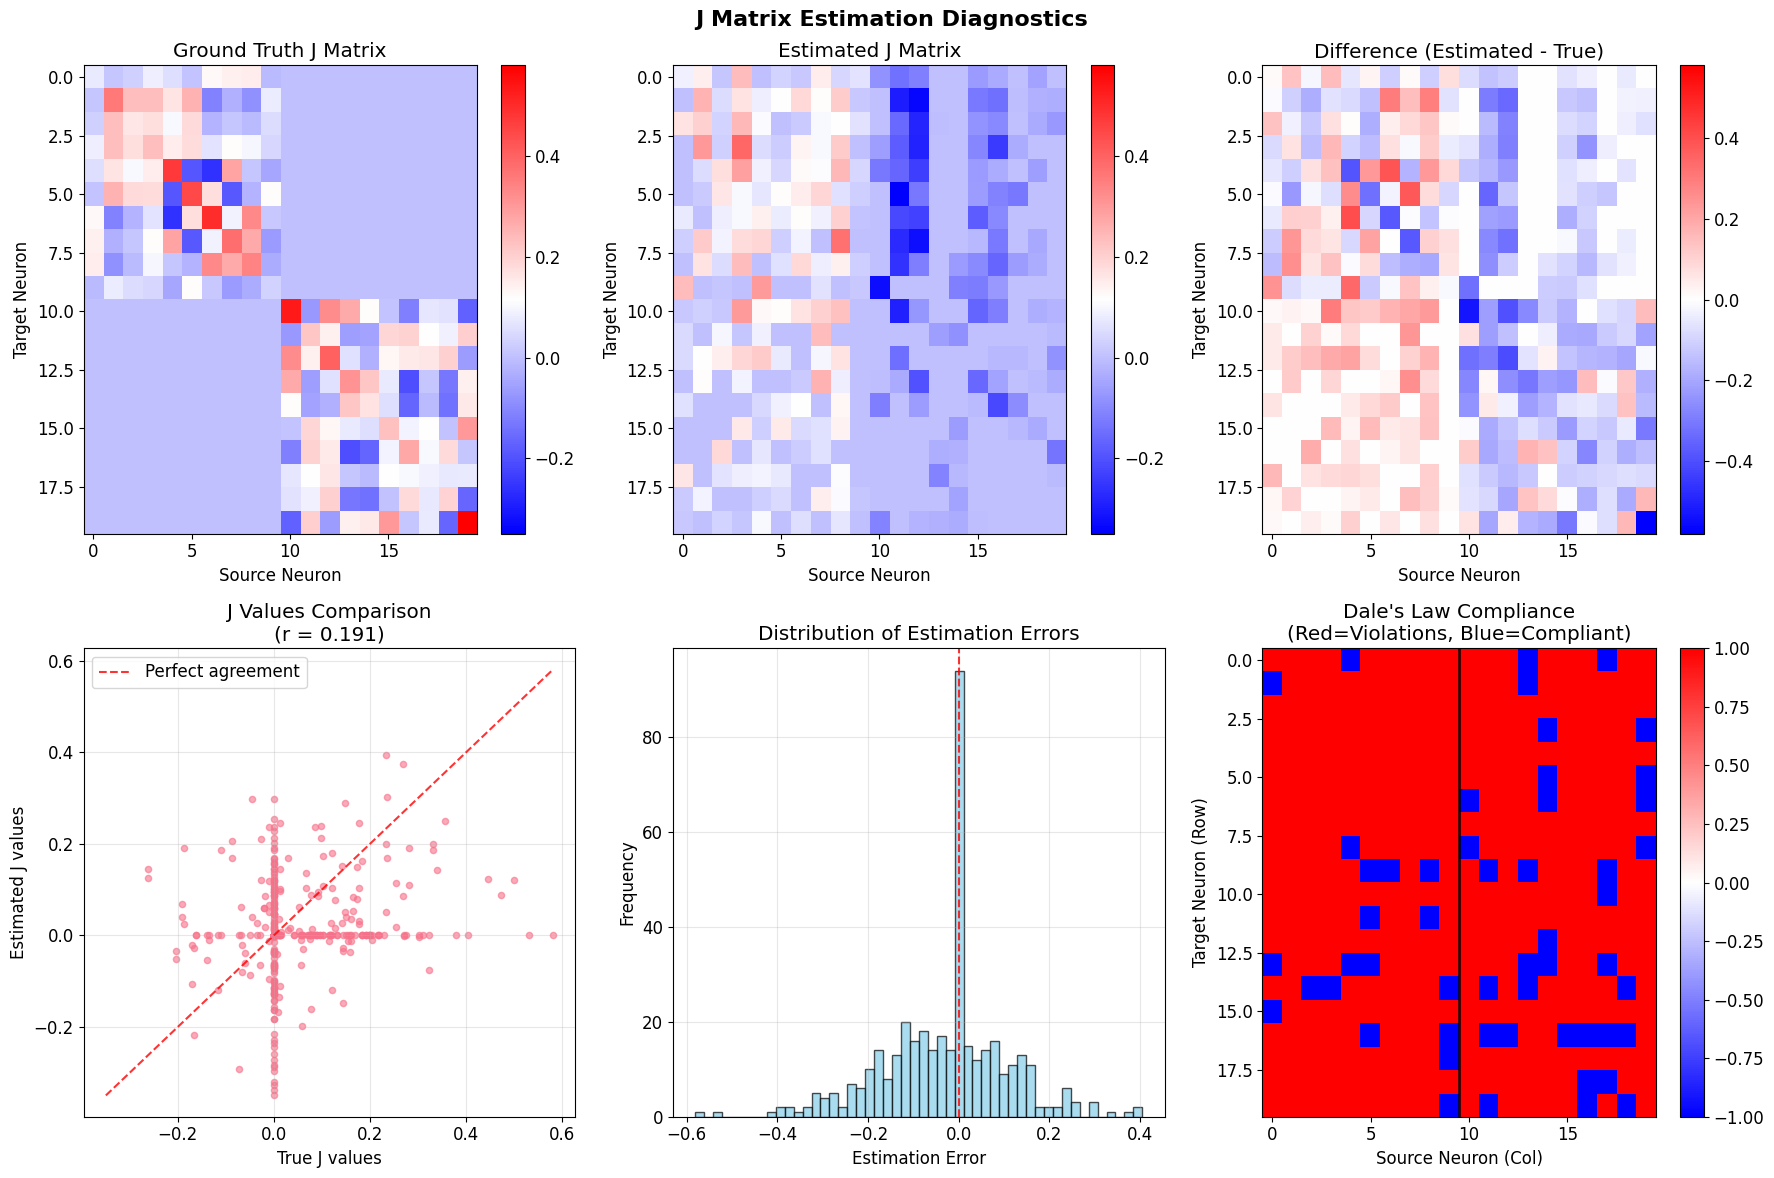

✅ J Matrix estimation diagnostics visualization completed!


In [5]:
# Visualize J matrices comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Determine color scale for consistent comparison
vmin = min(jnp.min(J_true), jnp.min(J_estimated))
vmax = max(jnp.max(J_true), jnp.max(J_estimated))

# Plot ground truth J
im1 = axes[0, 0].imshow(J_true, cmap='bwr',  vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 0].set_title('Ground Truth J Matrix')
axes[0, 0].set_xlabel('Source Neuron')
axes[0, 0].set_ylabel('Target Neuron')
plt.colorbar(im1, ax=axes[0, 0])

# Plot estimated J
im2 = axes[0, 1].imshow(J_estimated, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 1].set_title('Estimated J Matrix')
axes[0, 1].set_xlabel('Source Neuron')
axes[0, 1].set_ylabel('Target Neuron')
plt.colorbar(im2, ax=axes[0, 1])

# Plot difference (residual)
diff = J_estimated - J_true
im3 = axes[0, 2].imshow(diff, cmap='bwr', vmin=-jnp.max(jnp.abs(diff)), 
                       vmax=jnp.max(jnp.abs(diff)), aspect='auto')
axes[0, 2].set_title('Difference (Estimated - True)')
axes[0, 2].set_xlabel('Source Neuron')
axes[0, 2].set_ylabel('Target Neuron')
plt.colorbar(im3, ax=axes[0, 2])

# Scatter plot: estimated vs true
axes[1, 0].scatter(J_true.flatten(), J_estimated.flatten(), alpha=0.6, s=20)
axes[1, 0].plot([vmin, vmax], [vmin, vmax], 'r--', alpha=0.8, label='Perfect agreement')
axes[1, 0].set_xlabel('True J values')
axes[1, 0].set_ylabel('Estimated J values')
axes[1, 0].set_title(f'J Values Comparison\n(r = {j_metrics["correlation"]:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Histogram of differences
axes[1, 1].hist(diff.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Estimation Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Estimation Errors')
axes[1, 1].grid(True, alpha=0.3)

# Dale's law verification visualization
# Create a mask showing cell types
dale_vis = jnp.zeros_like(J_estimated)
for i, is_exc in enumerate(dale_mask):
    if is_exc:  # Excitatory
        dale_vis = dale_vis.at[:, i].set(1)  # Mark excitatory columns
    else:  # Inhibitory  
        dale_vis = dale_vis.at[:, i].set(-1)  # Mark inhibitory columns

# Color code: positive for excitatory columns, negative for inhibitory
im4 = axes[1, 2].imshow(dale_vis * jnp.sign(J_estimated), cmap='bwr', 
                       vmin=-1, vmax=1, aspect='auto')
axes[1, 2].set_title('Dale\'s Law Compliance\n(Red=Violations, Blue=Compliant)')
axes[1, 2].set_xlabel('Source Neuron (Col)')
axes[1, 2].set_ylabel('Target Neuron (Row)')

# Add vertical lines to separate cell types
exc_count = jnp.sum(dale_mask)
axes[1, 2].axvline(exc_count - 0.5, color='black', linewidth=2, alpha=0.8)

plt.colorbar(im4, ax=axes[1, 2])

plt.suptitle('J Matrix Estimation Diagnostics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ J Matrix estimation diagnostics visualization completed!")

## 2. Blockwise NMF Factorization Diagnostics

We perform blockwise Non-negative Matrix Factorization (NMF) on the absolute Dale matrix |J| and validate the factorization quality for each cell type.

In [6]:
print("🧩 BLOCKWISE NMF FACTORIZATION ANALYSIS")
print("=" * 55)

# Perform blockwise NMF on estimated J matrix
start_time = time.time()
block_factors = blockwise_NMF(J_estimated, cell_constraints)
nmf_time = time.time() - start_time

print(f"✅ Blockwise NMF Completed:")
print(f"  • NMF time: {nmf_time:.3f} seconds")
print(f"  • Number of cell types: {len(block_factors)}")

# Analyze each cell type block
def analyze_nmf_block(U, V, J_block, cell_type_idx, cell_type_label):
    """Analyze NMF factorization quality for a single cell type block."""
    
    # 1. Compute reconstruction
    J_reconstructed = U @ V.T
    
    # 2. Reconstruction error
    reconstruction_error = jnp.linalg.norm(J_block - J_reconstructed, 'fro')
    relative_error = reconstruction_error / jnp.linalg.norm(J_block, 'fro')
    
    # 3. Verify non-negativity
    U_negative_count = jnp.sum(U < -1e-10)
    V_negative_count = jnp.sum(V < -1e-10)
    
    # 4. Check factor variance (avoid degenerate cases)
    U_row_variances = jnp.var(U, axis=1)
    V_row_variances = jnp.var(V, axis=1)
    
    # Degenerate factors: all zeros or all ones
    U_zero_rows = jnp.sum(jnp.all(jnp.abs(U) < 1e-10, axis=1))
    V_zero_rows = jnp.sum(jnp.all(jnp.abs(V) < 1e-10, axis=1))
    
    # Near-constant rows (low variance)
    U_low_var_rows = jnp.sum(U_row_variances < 1e-6)
    V_low_var_rows = jnp.sum(V_row_variances < 1e-6)
    
    # 5. Frobenius norms
    U_norm = jnp.linalg.norm(U, 'fro')
    V_norm = jnp.linalg.norm(V, 'fro')
    
    # 6. Explained variance
    total_variance = jnp.var(J_block)
    residual_variance = jnp.var(J_block - J_reconstructed)
    explained_variance = 1 - (residual_variance / total_variance)
    
    return {
        'cell_type_idx': cell_type_idx,
        'cell_type_label': cell_type_label,
        'J_block_shape': J_block.shape,
        'U_shape': U.shape,
        'V_shape': V.shape,
        'reconstruction_error': reconstruction_error,
        'relative_error': relative_error,
        'U_negative_count': U_negative_count,
        'V_negative_count': V_negative_count,
        'U_zero_rows': U_zero_rows,
        'V_zero_rows': V_zero_rows,
        'U_low_var_rows': U_low_var_rows,
        'V_low_var_rows': V_low_var_rows,
        'U_norm': U_norm,
        'V_norm': V_norm,
        'explained_variance': explained_variance,
        'J_reconstructed': J_reconstructed
    }

# Analyze all cell type blocks
J_abs = jnp.abs(J_estimated)
block_analyses = []

for i, (U, V) in enumerate(block_factors):
    cell_type = cell_types[i]
    
    # Get indices for this cell type
    type_indices = jnp.where(cell_type_mask == cell_type)[0]
    
    # Extract the corresponding block from |J|
    J_block = J_abs[type_indices, :]
    
    # Analyze this block
    analysis = analyze_nmf_block(U, V, J_block, i, cell_type)
    block_analyses.append(analysis)
    
    # Print results
    print(f"\n📊 Cell Type {cell_type} (Block {i+1}):")
    print(f"  • Block shape: {analysis['J_block_shape']}")
    print(f"  • U shape: {analysis['U_shape']}, V shape: {analysis['V_shape']}")
    print(f"  • Relative reconstruction error: {analysis['relative_error']:.6f}")
    print(f"  • Explained variance: {analysis['explained_variance']:.4f}")
    print(f"  • Non-negativity violations: U={analysis['U_negative_count']}, V={analysis['V_negative_count']}")
    print(f"  • Degenerate factors: U zeros={analysis['U_zero_rows']}, V zeros={analysis['V_zero_rows']}")
    print(f"  • Low variance factors: U={analysis['U_low_var_rows']}, V={analysis['V_low_var_rows']}")
    print(f"  • Factor norms: ||U||_F={analysis['U_norm']:.3f}, ||V||_F={analysis['V_norm']:.3f}")

🧩 BLOCKWISE NMF FACTORIZATION ANALYSIS
✅ Blockwise NMF Completed:
  • NMF time: 3.910 seconds
  • Number of cell types: 2

📊 Cell Type 0 (Block 1):
  • Block shape: (10, 20)
  • U shape: (10, 3), V shape: (20, 3)
  • Relative reconstruction error: 0.307553
  • Explained variance: 0.8236
  • Non-negativity violations: U=1, V=6
  • Degenerate factors: U zeros=0, V zeros=0
  • Low variance factors: U=0, V=1
  • Factor norms: ||U||_F=0.405, ||V||_F=7.602

📊 Cell Type 1 (Block 2):
  • Block shape: (10, 20)
  • U shape: (10, 3), V shape: (20, 3)
  • Relative reconstruction error: 0.454440
  • Explained variance: 0.6990
  • Non-negativity violations: U=3, V=9
  • Degenerate factors: U zeros=0, V zeros=0
  • Low variance factors: U=0, V=0
  • Factor norms: ||U||_F=0.209, ||V||_F=7.552


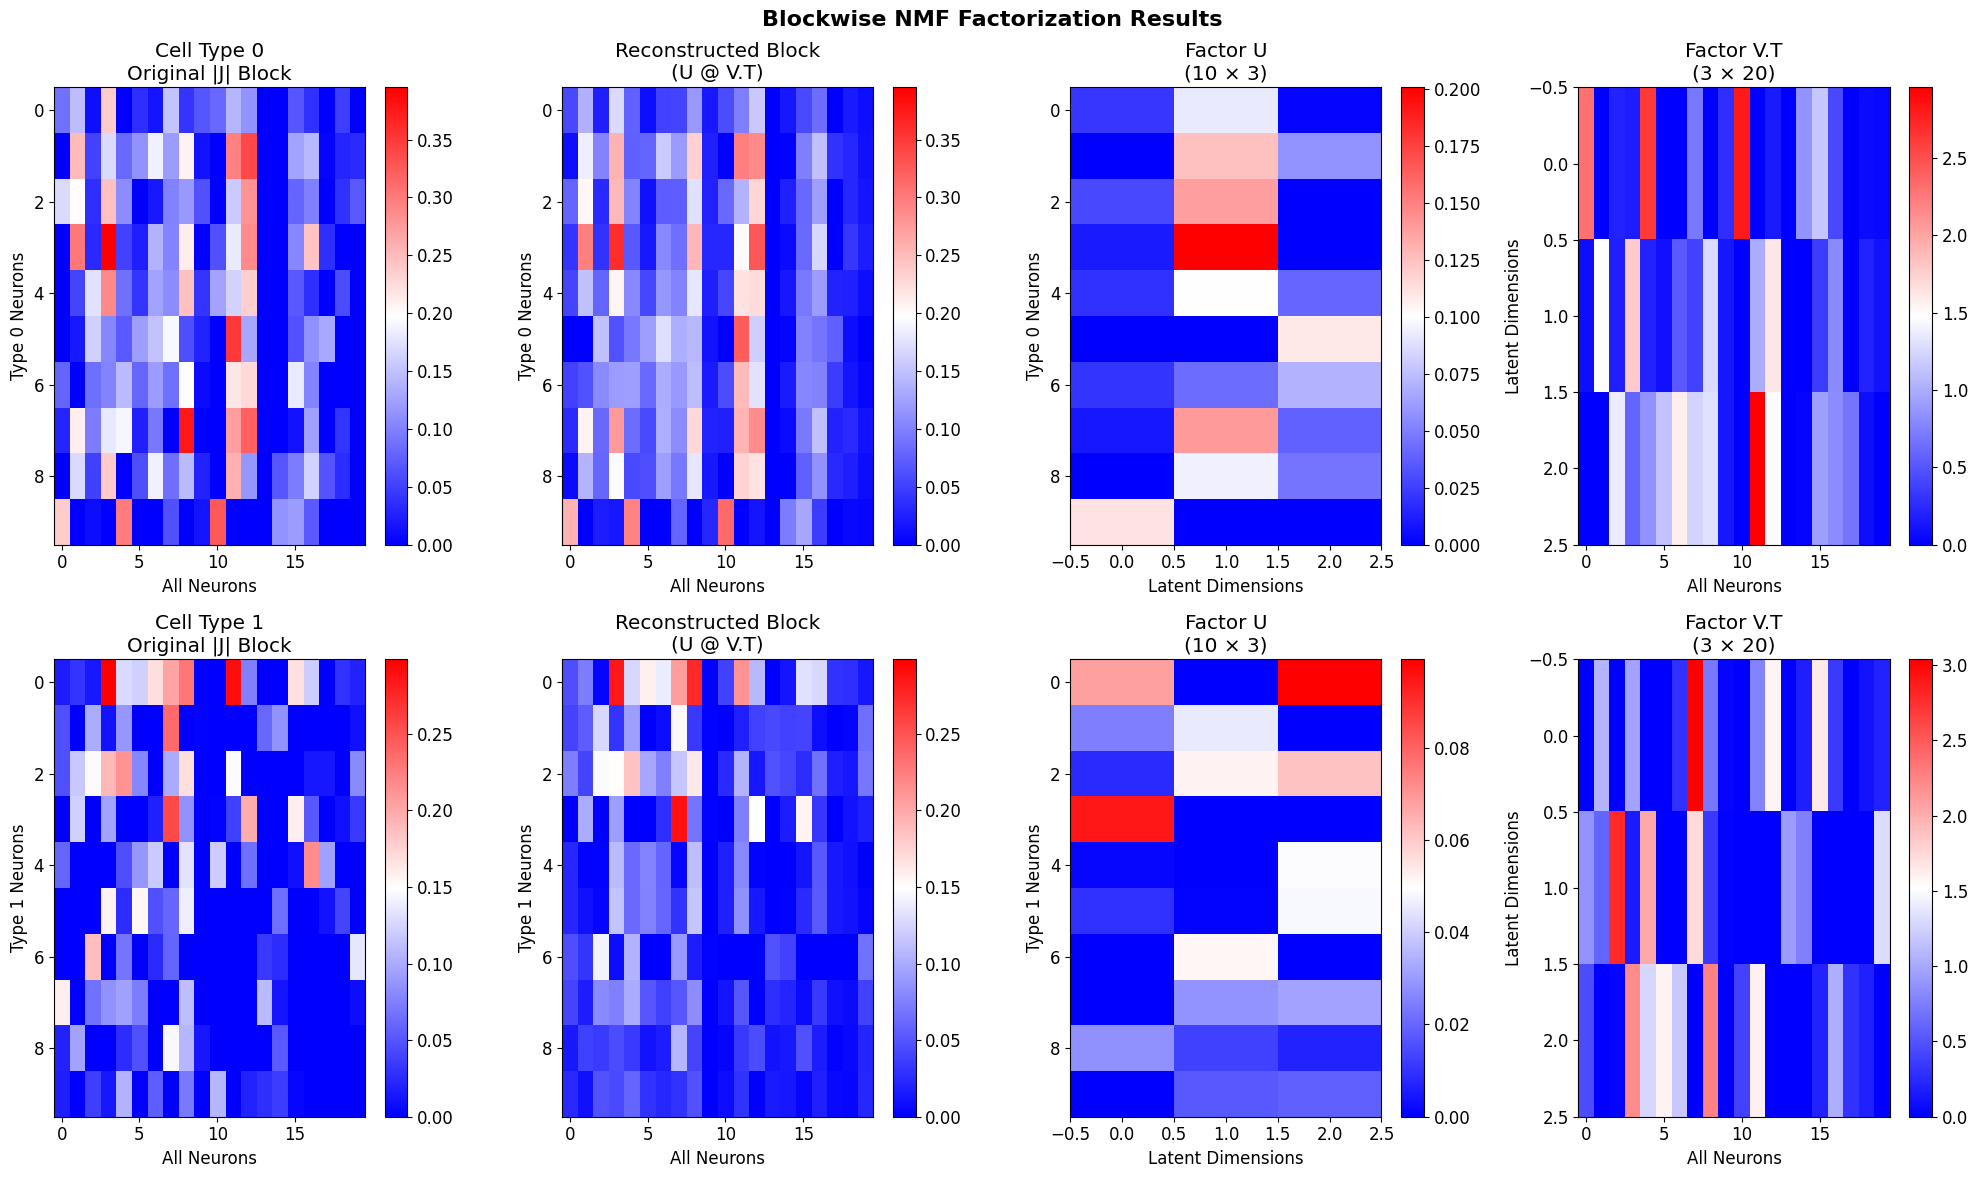

✅ Blockwise NMF visualization completed!


In [9]:
# Visualize NMF factorization results
n_cell_types = len(block_factors)
fig, axes = plt.subplots(n_cell_types, 4, figsize=(20, 6 * n_cell_types))

if n_cell_types == 1:
    axes = axes.reshape(1, -1)  # Ensure 2D array for indexing

for i, analysis in enumerate(block_analyses):
    U, V = block_factors[i]
    J_block = J_abs[jnp.where(cell_type_mask == cell_types[i])[0], :]
    J_reconstructed = analysis['J_reconstructed']
    
    # Determine color scale
    vmax = max(jnp.max(J_block), jnp.max(J_reconstructed))
    
    # Plot 1: Original block
    im1 = axes[i, 0].imshow(J_block, cmap='bwr', vmin=0, vmax=vmax, aspect='auto')
    axes[i, 0].set_title(f'Cell Type {cell_types[i]}\nOriginal |J| Block')
    axes[i, 0].set_xlabel('All Neurons')
    axes[i, 0].set_ylabel(f'Type {cell_types[i]} Neurons')
    plt.colorbar(im1, ax=axes[i, 0])
    
    # Plot 2: Reconstructed block
    im2 = axes[i, 1].imshow(J_reconstructed, cmap='bwr', vmin=0, vmax=vmax, aspect='auto')
    axes[i, 1].set_title(f'Reconstructed Block\n(U @ V.T)')
    axes[i, 1].set_xlabel('All Neurons')
    axes[i, 1].set_ylabel(f'Type {cell_types[i]} Neurons')
    plt.colorbar(im2, ax=axes[i, 1])
    
    # Plot 3: Factor U
    im3 = axes[i, 2].imshow(U, cmap='bwr', vmin=0, aspect='auto')
    axes[i, 2].set_title(f'Factor U\n({U.shape[0]} × {U.shape[1]})')
    axes[i, 2].set_xlabel('Latent Dimensions')
    axes[i, 2].set_ylabel(f'Type {cell_types[i]} Neurons')
    plt.colorbar(im3, ax=axes[i, 2])
    
    # Plot 4: Factor V (transposed for visualization)
    im4 = axes[i, 3].imshow(V.T, cmap='bwr', vmin=0, aspect='auto')
    axes[i, 3].set_title(f'Factor V.T\n({V.shape[1]} × {V.shape[0]})')
    axes[i, 3].set_xlabel('All Neurons')
    axes[i, 3].set_ylabel('Latent Dimensions')
    plt.colorbar(im4, ax=axes[i, 3])

plt.suptitle('Blockwise NMF Factorization Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Blockwise NMF visualization completed!")

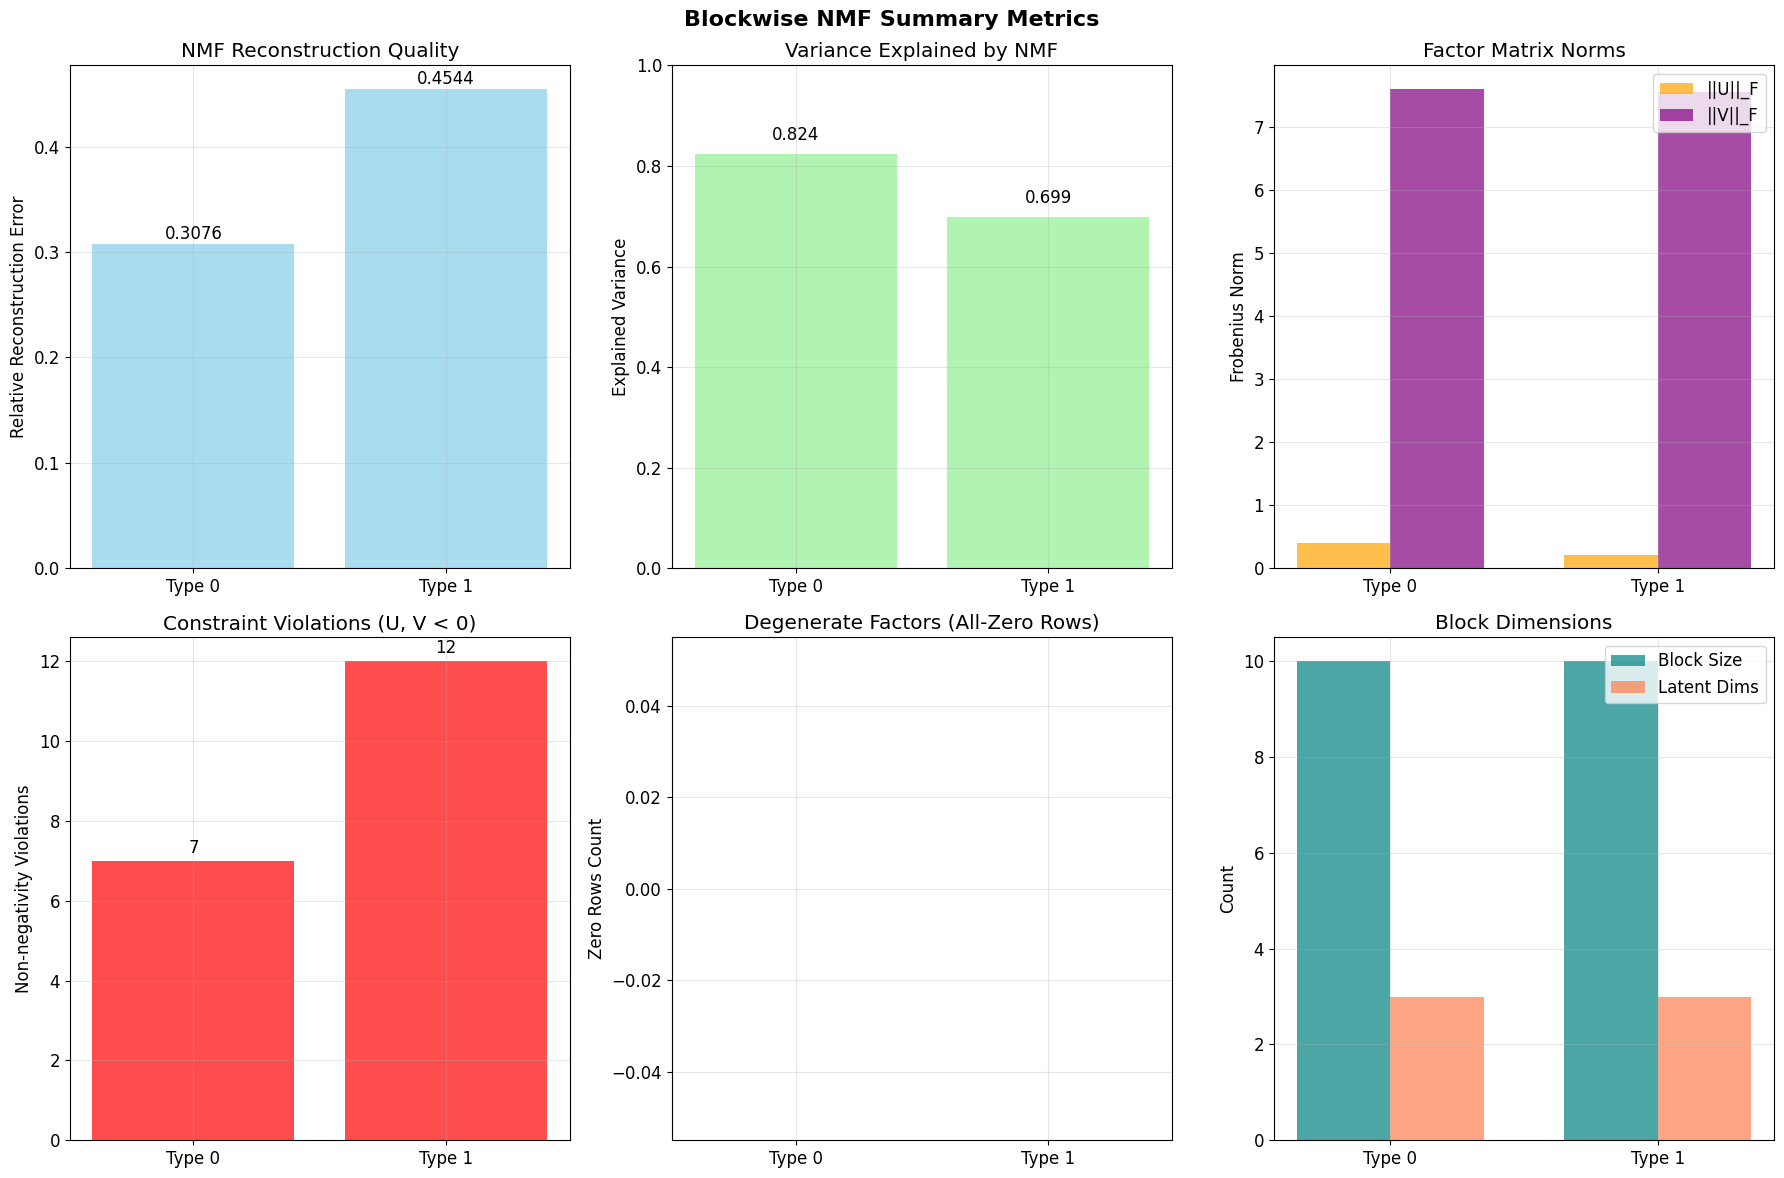


📋 CTDS INITIALIZATION DIAGNOSTICS SUMMARY

🎯 J Matrix Estimation:
  • Correlation with ground truth: 0.1911
  • Relative Frobenius error: 1.1704
  • Dale's law compliance: 85.0%
  • Prediction R²: 0.4312

🧩 Blockwise NMF Factorization:
  • Average reconstruction error: 0.380997
  • Average explained variance: 0.7613
  • Total non-negativity violations: 19
  • Total degenerate factors: 0

⏱️ Computational Performance:
  • J estimation time: 2.669s
  • NMF factorization time: 3.910s
  • Total initialization time: 6.579s

✅ Diagnostics completed successfully!


In [8]:
# Summary metrics and comparison across cell types
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Extract metrics for comparison
cell_type_labels = [f"Type {analysis['cell_type_label']}" for analysis in block_analyses]
relative_errors = [analysis['relative_error'] for analysis in block_analyses]
explained_variances = [analysis['explained_variance'] for analysis in block_analyses]
U_norms = [analysis['U_norm'] for analysis in block_analyses]
V_norms = [analysis['V_norm'] for analysis in block_analyses]
total_violations = [analysis['U_negative_count'] + analysis['V_negative_count'] for analysis in block_analyses]
degenerate_factors = [analysis['U_zero_rows'] + analysis['V_zero_rows'] for analysis in block_analyses]

# Plot 1: Reconstruction errors
bars1 = axes[0, 0].bar(cell_type_labels, relative_errors, alpha=0.7, color='skyblue')
axes[0, 0].set_ylabel('Relative Reconstruction Error')
axes[0, 0].set_title('NMF Reconstruction Quality')
axes[0, 0].grid(True, alpha=0.3)
# Add value labels
for bar, value in zip(bars1, relative_errors):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.4f}', ha='center', va='bottom')

# Plot 2: Explained variance
bars2 = axes[0, 1].bar(cell_type_labels, explained_variances, alpha=0.7, color='lightgreen')
axes[0, 1].set_ylabel('Explained Variance')
axes[0, 1].set_title('Variance Explained by NMF')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3)
for bar, value in zip(bars2, explained_variances):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{value:.3f}', ha='center', va='bottom')

# Plot 3: Factor norms
x = jnp.arange(len(cell_type_labels))
width = 0.35
axes[0, 2].bar(x - width/2, U_norms, width, label='||U||_F', alpha=0.7, color='orange')
axes[0, 2].bar(x + width/2, V_norms, width, label='||V||_F', alpha=0.7, color='purple')
axes[0, 2].set_ylabel('Frobenius Norm')
axes[0, 2].set_title('Factor Matrix Norms')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(cell_type_labels)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Constraint violations
bars4 = axes[1, 0].bar(cell_type_labels, total_violations, alpha=0.7, color='red')
axes[1, 0].set_ylabel('Non-negativity Violations')
axes[1, 0].set_title('Constraint Violations (U, V < 0)')
axes[1, 0].grid(True, alpha=0.3)
for bar, value in zip(bars4, total_violations):
    if value > 0:
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       f'{int(value)}', ha='center', va='bottom')

# Plot 5: Degenerate factors
bars5 = axes[1, 1].bar(cell_type_labels, degenerate_factors, alpha=0.7, color='gold')
axes[1, 1].set_ylabel('Zero Rows Count')
axes[1, 1].set_title('Degenerate Factors (All-Zero Rows)')
axes[1, 1].grid(True, alpha=0.3)
for bar, value in zip(bars5, degenerate_factors):
    if value > 0:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                       f'{int(value)}', ha='center', va='bottom')

# Plot 6: Block dimensions summary
block_sizes = [analysis['J_block_shape'][0] for analysis in block_analyses]
latent_dims = [analysis['U_shape'][1] for analysis in block_analyses]

axes[1, 2].bar(x - width/2, block_sizes, width, label='Block Size', alpha=0.7, color='teal')
axes[1, 2].bar(x + width/2, latent_dims, width, label='Latent Dims', alpha=0.7, color='coral')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Block Dimensions')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(cell_type_labels)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Blockwise NMF Summary Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print overall summary
print("\n" + "=" * 60)
print("📋 CTDS INITIALIZATION DIAGNOSTICS SUMMARY")
print("=" * 60)

print(f"\n🎯 J Matrix Estimation:")
print(f"  • Correlation with ground truth: {j_metrics['correlation']:.4f}")
print(f"  • Relative Frobenius error: {j_metrics['frobenius_error']:.4f}")
print(f"  • Dale's law compliance: {compliance_rate:.1f}%")
print(f"  • Prediction R²: {j_metrics['r2_prediction']:.4f}")

print(f"\n🧩 Blockwise NMF Factorization:")
avg_rel_error = jnp.mean(jnp.array(relative_errors))
avg_explained_var = jnp.mean(jnp.array(explained_variances))
total_violations_all = sum(total_violations)
total_degenerate = sum(degenerate_factors)

print(f"  • Average reconstruction error: {avg_rel_error:.6f}")
print(f"  • Average explained variance: {avg_explained_var:.4f}")
print(f"  • Total non-negativity violations: {total_violations_all}")
print(f"  • Total degenerate factors: {total_degenerate}")

print(f"\n⏱️ Computational Performance:")
print(f"  • J estimation time: {estimation_time:.3f}s")
print(f"  • NMF factorization time: {nmf_time:.3f}s")
print(f"  • Total initialization time: {estimation_time + nmf_time:.3f}s")

print("\n✅ Diagnostics completed successfully!")